<h1 align=center>Indo mais fundo – A mecânica do TensorFlow</h1>
<p align=center><img src=https://cdn.shortpixel.ai/spai/w_912+q_+ret_img+to_webp/https://iaexpert.academy/wp-content/uploads/2021/01/26.01.png width = 500></p>

Agora que temos alguma experiência prática com treinamento de uma Rede Neural (RN) do *TensorFlow* e aprendizado de máquina, é hora de mergulhar mais fundo na biblioteca do *TensorFlow* e explorar seu rico conjunto de recursos, o que nos permitirá implementar um aprendizado profundo mais avançado modelos nas próximas etapas.

Usaremos diferentes aspectos da API do *TensorFlow* para implementar as RNs. Em particular, usaremos novamente a API *Keras*, que fornece várias camadas de abstração para tornar a implementação de arquiteturas padrão muito conveniente. O *TensorFlow* também nos permite implementar camadas RNs personalizadas, o que é muito útil em projetos orientados à pesquisa que exigem mais personalização. Mais adiante, implementaremos essa camada personalizada.

Para ilustrar as diferentes formas de construção de modelos usando a API *Keras*, também consideraremos o problema clássico **exclusivo ou (XOR)**. Primeiramente, construiremos perceptrons multicamadas usando a classe `Sequential`. Em seguida, consideraremos outros métodos, como subclassificar `tf.keras.Model` para definir camadas personalizadas. Por fim, abordaremos o `tf.estimator`, uma API *TensorFlow* de alto nível que encapsula as etapas de aprendizado de máquina da entrada bruta à previsão.

### Como criar um gráfico no *TensorFlow* v1.x
Na versão anterior da API de baixo nível do *TensorFlow* (v1.x), esse gráfico precisava ser declarado explicitamente. As etapas individuais para criar, compilar e avaliar esse gráfico de computação no *TensorFlow* v1.x são as seguintes:
1. Instanciar um novo gráfico de computação vazio
2. Adicione nós (tensores e operações) ao gráfico de computação
3. Avalie (execute) o gráfico:
* Iniciar uma nova sessão
* Inicialize as variáveis ​​no gráfico
* Execute o gráfico de computação nesta sessão

Antes de darmos uma olhada na abordagem dinâmica no *TensorFlow* v2, vamos ver um exemplo simples que ilustra como criar um gráfico no *TensorFlow* v1.x para calcular $\small z = 2 \times (a-b) + c$. As variáveis $​​\small a$, $​​\small b$ e $​​\small c$ são escalares (números únicos) e definimos como constantes do *TensorFlow*. Um gráfico pode então ser criado chamando `tf.Graph()`. As variáveis, assim como os cálculos, representam os nós do gráfico, que definiremos da seguinte forma:

In [1]:
import logging
import tensorflow as tf
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [2]:
## TF v1.x style
import tensorflow as tf
g = tf.Graph()

with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2*(a-b) + c


Neste código, primeiro definimos o gráfico `g` via `g=tf.Graph()`. Em seguida, adicionamos nós ao gráfico, `g`, usando com `g.as_default()`. No entanto, observe que, se não criarmos um gráfico explicitamente, sempre haverá um gráfico padrão ao qual variáveis ​​e cálculos serão adicionados automaticamente.

No *TensorFlow* v1.x, uma sessão é um ambiente no qual as operações e os tensores de um gráfico podem ser executados. A classe `Session` foi removida do *TensorFlow* v2; No entanto, por enquanto, ele ainda está disponível por meio do submódulo `tf.compat` para permitir a compatibilidade com o *TensorFlow* v1.x. Um objeto de sessão pode ser criado chamando `tf.compat.v1.Session()`, que pode receber um gráfico existente (no caso, `g`) como argumento, como em `Session(graph=g)`.

Após lançar um gráfico em uma sessão do *TensorFlow*, podemos executar seus nós, ou seja, avaliar seus tensores ou executar seus operadores. Avaliar cada tensor individual envolve chamar seu método `eval()` dentro da sessão atual. Ao avaliar um tensor específico no gráfico, o *TensorFlow* precisa executar todos os nós anteriores no gráfico até atingir o nó de interesse fornecido. Caso haja uma ou mais variáveis *​​placeholder*, também precisamos fornecer valores para elas através do método `run` da sessão, como veremos mais adiante.

Depois de definir o gráfico estático no trecho de código anterior, podemos executar o gráfico em uma sessão do *TensorFlow* e avaliar o tensor, `z`, da seguinte forma:

In [3]:
## TF v1.x style

with tf.compat.v1.Session(graph=g) as sess:
    print('Result: z = ', sess.run(z))

Result: z =  1


### Como migrar um gráfico para o *TensorFlow* v2

Em seguida, vamos ver como esse código pode ser migrado para o *TensorFlow* v2. O *TensorFlow* v2 usa gráficos dinâmicos (em oposição aos estáticos) por padrão (isso também é chamado de execução antecipada no *TensorFlow*), o que nos permite avaliar uma operação em tempo real. Portanto, não precisamos criar explicitamente um gráfico e uma sessão, o que torna o fluxo de trabalho de desenvolvimento muito mais conveniente:

In [4]:
## TF v2 Style
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c

tf.print('Result: z = ', z)



Result: z =  1


### Carregando dados de entrada em um modelo: estilo *TensorFlow* v1.x

Outra melhoria importante do *TensorFlow* v1.x para v2 diz respeito a como os dados podem ser carregados em nossos modelos. No *TensorFlow* v2, podemos alimentar dados diretamente na forma de variáveis *Python* ou arrays *NumPy*. No entanto, ao usar a API de baixo nível do *TensorFlow* v1.x, tivemos que criar variáveis de espaço reservado para fornecer dados de entrada a um modelo. Para o exemplo de gráfico de computação simples anterior, $\small z = 2 \times (a-b) + c$, vamos supor que `a`, `b` e `c` são os tensores de entrada de *Rank* 0. Podemos então definir três espaços reservados, que usaremos para "feed" dados para o modelo por meio de um dicionário *feed_dict*, da seguinte forma:

In [5]:
## TF-v1.x style
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a - b) + c
    
with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('Result: z =', sess.run(z, feed_dict=feed_dict))

Result: z = 1


### Carregando dados de entrada em um modelo: estilo *TensorFlow* v2

No *TensorFlow* v2, tudo isso pode ser feito simplesmente definindo uma função *Python* regular com `a`, `b` e `c` como seus argumentos de entrada, por exemplo:

In [6]:
## TF-v2 style
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

Agora, para realizar o cálculo, podemos simplesmente chamar essa função com objetos `Tensor` como argumentos de função. Observe que as funções do *TensorFlow*, como `add`, `subtract` e `multiply`, também nos permitem fornecer entradas de classificações mais altas na forma de um objeto *TensorFlow* `Tensor`, um array *NumPy* ou possivelmente outros objetos *Python*, como listas e tuplas. No exemplo de código a seguir, fornecemos entradas escalares (*Rank* 0), bem como entradas de *Rank* 1 e *Rank* 2, como listas:

In [7]:
tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


### Melhorando o desempenho computacional com decoradores de função

Como você viu na seção anterior, podemos escrever facilmente uma função *Python* normal e utilizar as operações do *TensorFlow*. No entanto, os cálculos por meio do modo de execução antecipada (gráfico dinâmico) não são tão eficientes quanto a execução de gráfico estático no *TensorFlow* v1.x. Assim, o *TensorFlow* v2 fornece uma ferramenta chamada **AutoGraph** que pode transformar automaticamente o código *Python* no código gráfico do *TensorFlow* para uma execução mais rápida. Além disso, o *TensorFlow* fornece um mecanismo simples para compilar uma função *Python* normal em um gráfico estático do *TensorFlow* para tornar os cálculos mais eficientes.

Para ver como isso funciona na prática, vamos trabalhar com nossa função `compute_z` anterior e anotá-la para compilação de gráfico usando o decorador `@tf.function`:

In [8]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

Observe que podemos usar e chamar essa função da mesma maneira que antes, mas agora o *TensorFlow* construirá um gráfico estático com base nos argumentos de entrada. *Python* suporta tipagem dinâmica e polimorfismo, então podemos definir uma função como `def f(a, b): return a+b` e chame-a usando entradas de *inteiro*, *float*, *list* ou *string* (lembre-se de que `a+b` é um valor válido operação para listas e *strings*). Embora os gráficos do *TensorFlow* exijam tipos e formas estáticos, o `tf.function` oferece suporte a esse recurso de digitação dinâmica. Por exemplo, vamos chamar esta função com as seguintes entradas:

In [9]:
tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


Veja que foi produzido as mesmas saídas de antes. Aqui, o *TensorFlow* usa um mecanismo de rastreamento para construir um gráfico com base nos argumentos de entrada. Para esse mecanismo de rastreamento, o *TensorFlow* gera uma tupla de chaves com base nas assinaturas de entrada fornecidas para chamar a função. As chaves geradas são as seguintes:

* Para argumentos `tf.Tensor`, a chave é baseada em seus *shapes* e *dtypes*.
* Para tipos *Python*, como listas, seu `id()` é usado para gerar chaves de cache.
* Para valores primitivos do *Python*, as chaves de cache são baseadas nos valores de entrada.

Ao chamar essa função decorada, o *TensorFlow* verificará se um gráfico com a chave correspondente já foi gerado. Se esse gráfico não existir, o *TensorFlow* gerará um novo gráfico e armazenará a nova chave. Por outro lado, se quisermos limitar a forma como uma função pode ser chamada, podemos especificar sua assinatura de entrada por meio de uma tupla de objetos `tf.TensorSpec` ao definir a função. Por exemplo, vamos redefinir a função anterior, `compute_z`, e especificar que apenas tensores de rank 1 do tipo `tf.int32` são permitidos:

In [10]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),))
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

Agora, podemos chamar esta função usando tensores de rank 1 (ou listas que podem ser convertidas em tensores de rank 1):

In [11]:
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 1 Inputs:', compute_z([1, 2], [2, 4], [3, 6]))

Rank 1 Inputs: [1]
Rank 1 Inputs: [1 2]


No entanto, chamar essa função usando tensores com classificações diferentes de 1 resultará em um erro, pois a classificação não corresponderá à assinatura de entrada especificada, conforme a seguir:

In [12]:
#tf.print('Rank 0 Inputs:', compute_z(1, 2, 3))

# Gera um erro
''' ValueError: Python inputs incompatible with input_signature:
  inputs: (
    1,
    2,
    3)
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).'''

' ValueError: Python inputs incompatible with input_signature:\n  inputs: (\n    1,\n    2,\n    3)\n  input_signature: (\n    TensorSpec(shape=(None,), dtype=tf.int32, name=None),\n    TensorSpec(shape=(None,), dtype=tf.int32, name=None),\n    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).'

In [13]:
#tf.print('Rank 2 Inputs:', compute_z([[1], [2]], [[2], [4]], [[3], [6]]))

""""
ValueError: Python inputs incompatible with input_signature:
  inputs: (
    [[1], [2]],
    [[2], [4]],
    [[3], [6]])
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).
"""

'"\nValueError: Python inputs incompatible with input_signature:\n  inputs: (\n    [[1], [2]],\n    [[2], [4]],\n    [[3], [6]])\n  input_signature: (\n    TensorSpec(shape=(None,), dtype=tf.int32, name=None),\n    TensorSpec(shape=(None,), dtype=tf.int32, name=None),\n    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).\n'

### Objetos variáveis do *TensorFlow* para armazenar e atualizar os parâmetros do modelo

No contexto do *TensorFlow*, uma `Variable` é um objeto Tensor especial que nos permite armazenar e atualizar os parâmetros de nossos modelos durante o treinamento. Um `Variable` pode ser criada apenas chamando a classe `tf.Variable` em valores iniciais especificados pelo usuário. No código a seguir, vamos gerar objetos `Variable` do tipo `float32`, `int32`, `bool` e `string`:

In [14]:
a = tf.Variable(initial_value=3.14, name='var_a')
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(a)
print(b)
print(c)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3])>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


Observe que sempre temos que fornecer os valores iniciais ao criar um `Variable`. As variáveis têm um atributo chamado `treinable`, que, por padrão, é definido como `True`. APIs de nível superior, como *Keras*, usarão esse atributo para gerenciar as variáveis treináveis e não treináveis. Você pode definir um `Variable` não treinável da seguinte forma:

In [15]:
w = tf.Variable([1,2,3], trainable=False)

print(w.trainable)

False


Os valores de um `Variable` podem ser modificados de forma eficiente executando algumas operações como `.assign()`, `.assign_add()` e métodos relacionados. Vejamos alguns exemplos:

In [16]:
print(w.assign([3,1,4], read_value=True))

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4])>


In [17]:
w.assign_add([2,-1,2], read_value=False)

print(w.value())

tf.Tensor([5 0 6], shape=(3,), dtype=int32)


Quando o argumento `read_value` estiver definido como `True` (que também é o padrão), essas operações retornarão automaticamente os novos valores após atualizar os valores atuais da `Variable`. Definir o `read_value` como `False` suprimirá o retorno automático do valor atualizado (mas a `Variable` ainda será atualizada no local). Chamar `w.value()` retornará os valores em um formato de tensor. Observe que não podemos alterar a forma ou o tipo da `Variable` durante a atribuição.

Você deve se lembrar de que, para modelos de Rede Neural, é necessário inicializar os parâmetros do modelo com pesos aleatórios para quebrar a simetria durante a retropropagação - caso contrário, uma RN multicamada não seria mais útil do que uma RN de camada única, como regressão logística. Ao criar uma variável do *TensorFlow*, também podemos usar um esquema de inicialização aleatório. O *TensorFlow* pode gerar números aleatórios com base em várias distribuições via `tf.random`.

No exemplo a seguir, veremos alguns métodos de inicialização padrão que também estão disponíveis no *Keras*. Então, vamos ver como podemos criar uma `Variable` com inicialização *Glorot*, que é um esquema clássico de inicialização aleatória que foi proposto por Xavier Glorot e Yoshua Bengio. Para isso, criamos um operador chamado `init` como objeto da classe `GlorotNormal`. Então, chamamos esse operador e fornecemos a forma desejada do tensor de saída:

In [18]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))

[-0.722795904 1.01456821 0.251808226]


Agora, podemos usar este operador para inicializar uma `Variable` de formato 2 × 3 :

In [19]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292783 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


Agora, para colocar isso no contexto de um caso de uso mais prático, vamos ver como podemos definir uma `Variable` dentro da classe base `tf.Module`. Vamos definir duas variáveis: uma treinável e uma não treinável:

In [20]:
class MyModule (tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2,3)),
                                    trainable=True)
        self.w2 = tf.Variable(init(shape=(1,2)),
                                trainable = False)

m = MyModule()

print('All module variables:', [v.shape for v in m.variables])

print('Trainable variable:  ', [v.shape for v in m.trainable_variables])



All module variables: [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variable:   [TensorShape([2, 3])]


Como você pode ver neste exemplo de código, a subclasse da classe `tf.Module` nos dá acesso direto a todas as variáveis definidas em um determinado objeto (aqui, uma instância de nossa classe `MyModule` personalizada) por meio do atributo `.variables`.

Finalmente, vamos ver como usar variáveis dentro de uma função decorada com `tf.function`. Quando definimos uma `Variable` do TensorFlow dentro de uma função normal (não decorada), podemos esperar que uma nova `Variable` seja criada e inicializada toda vez que a função for chamada. No entanto, `tf.function` tentará reutilizar a `Variable` com base no rastreamento e na criação do gráfico. Portanto, o *TensorFlow* não permite a criação de uma `Variable` dentro de uma função decorada e, como resultado, o código a seguir gerará um erro:

In [21]:
""""
@tf.function
def f(x):
    w = tf.Variable([1,2,3])

f([1])

"""

'"\n@tf.function\ndef f(x):\n    w = tf.Variable([1,2,3])\n\nf([1])\n\n'

Uma maneira de evitar esse problema é definir a variável fora da função decorada e usá-la dentro da função:

In [22]:
w = tf.Variable(tf.random.uniform((3, 3)))

@ tf.function
def compute_z(x):
    return tf.matmul(w , x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)

tf.print(compute_z(x))

[[1.20935762]
 [3.89828062]
 [1.65398622]]


### Computação de gradientes via diferenciação automática e *GradientTape*

Como você já sabe, otimizar RNs requer calcular os gradientes do custo em relação aos pesos da Rn. Isso é necessário para algoritmos de otimização, como gradiente descendente estocástico (SGD). Além disso, os gradientes têm outras aplicações, como diagnosticar a rede para descobrir por que um modelo de RN está fazendo uma previsão específica para um exemplo de teste. Portanto, nesta seção, abordaremos como calcular gradientes de uma computação em relação a algumas variáveis.

### Calculando os gradientes da perda em relação às variáveis ​​treináveis

O *TensorFlow* oferece suporte à **diferenciação automática**, que pode ser considerada uma implementação da regra da cadeia para calcular gradientes de funções aninhadas. Quando definimos uma série de operações que resultam em alguma saída ou mesmo tensores intermediários, o *TensorFlow* fornece um contexto para calcular gradientes desses tensores calculados em relação a seus nós dependentes no gráfico de computação. Para calcular esses gradientes, temos que "gravar" os cálculos via `tf.GradientTape`.

Vamos trabalhar com um exemplo simples onde vamos calcular $\small z = wx + b$ e definir a perda como a perda ao quadrado entre o alvo e a previsão, $\small Loss = (y - z)^2$. No caso mais geral, onde podemos ter várias previsões e metas, calcule a perda como a soma do erro ao quadrado, $\small Loss = \sum_i(y_i - z_i)^2$. Para implementar esse cálculo no *TensorFlow*, vamos definir os parâmetros do modelo, $\small w$ e $\small b$, como variáveis, e as entradas $\small x$ e $\small y$, como tensores. Colocaremos o cálculo de $\small z$ e a perda dentro do contexto `tf.GradientTape`:

In [23]:
import tensorflow as tf

w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

True True


In [24]:
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)

tf.print('dL/dw : ', dloss_dw)

dL/dw :  -0.559999764


Ao calcular o valor $\small z$, podemos pensar nas operações necessárias, que gravamos na "gradient tape", como uma passagem para frente em uma RN. Usamos `tape.gradient` para calcular $\small \dfrac{\partial Loss}{\partial w}$ . Como este é um exemplo muito simples, podemos obter as derivadas, $\small \dfrac {\partial Loss}{\partial w} = 2x(wx + b - y)$, simbolicamente para verificar que os gradientes calculados obtivemos no exemplo de código anterior:

In [25]:
# verifying the computed gradient
tf.print(2*x*(w*x  + b - y))

[-0.559999764]


### Computação de gradientes em relação a tensores não treináveis

`tf.GradientTape` suporta automaticamente os gradientes para variáveis treináveis. No entanto, para variáveis não treináveis e outros objetos `Tensor`, precisamos adicionar uma modificação adicional ao `GradientTape` chamada `tape.watch()` para monitorá-los também. Por exemplo, se estivermos interessados em calcular $\small \dfrac {\partial Loss}{\partial x}$ , o código será o seguinte:

In [26]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)

tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


In [27]:
# verifying the computed gradient
tf.print(2*w * ((w*x + b) - y))

[-0.399999857]


### Mantendo recursos para vários cálculos de gradiente
Quando monitoramos os cálculos no contexto de`tf.GradientTape`, por padrão, a fita manterá os recursos apenas para um único cálculo de gradiente. Por exemplo, após chamar `tape.gradient()` uma vez, os recursos serão liberados e a fita será limpa. Portanto, se quisermos calcular mais de um gradiente, por exemplo, ambos $\small \dfrac {\partial Loss}{\partial w}$ e $\small \dfrac {\partial Loss}{\partial b}$ , precisamos tornar a fita persistente:

In [28]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


In [29]:
tf.print(2*x * ((w*x + b) - y))

[-0.559999764]


No entanto, lembre-se de que isso só é necessário quando queremos calcular mais de um gradiente, pois gravar e manter a fita gradiente é menos eficiente em termos de memória em comparação com liberar a memória após um único cálculo de gradiente. É também por isso que a configuração padrão é `persistent=False`.

Finalmente, se estivermos computando gradientes de um termo de perda em relação aos parâmetros de um modelo, podemos definir um otimizador e aplicar os gradientes para otimizar os parâmetros do modelo usando a API `tf.keras`, como segue:

In [30]:
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('Updated w:', w)
tf.print('Updated bias:', b)

Updated w: 1.0056
Updated bias: 0.504


Você deve se lembrar que o peso inicial e a unidade de viés eram $\small w$ = 1,0 e $\small b$ = 0,5, e a aplicação dos gradientes da perda em relação aos parâmetros do modelo mudou os parâmetros do modelo para $\small w$ = 1,0056 e $\small b$ = 0,504.

### Simplificando implementações de arquiteturas comuns por meio da API *Keras*
Você já viu alguns exemplos de construção de um modelo de RN *feedforward* (por exemplo, um *perceptron* multicamadas) e definição de uma sequência de camadas usando a classe `Sequential` do *Keras*. Antes de examinarmos diferentes abordagens para configurar essas camadas, vamos recapitular brevemente as etapas básicas construindo um modelo com duas camadas densamente (totalmente) conectadas:

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

# late variable creation

model.build(input_shape=(None,4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


Especificamos a forma de entrada com `model.build()`, instanciando as variáveis após definir o modelo para essa forma específica. O número de parâmetros de cada camada é exibido: $\small 16 × 4 + 16 = 80$ para a primeira camada e $\small 16 × 32 + 32 = 544$ para a segunda camada. Depois que as variáveis (ou parâmetros do modelo) são criadas, podemos acessar as variáveis treináveis e não treináveis da seguinte forma:

In [32]:
# Apresentado as variáveis do modelo.
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


Nesse caso, cada camada possui uma matriz de pesos chamada `kernel`, bem como um vetor de polarização.

Em seguida, vamos configurar essas camadas, por exemplo, aplicando diferentes funções de ativação, inicializadores de variáveis ou métodos de regularização aos parâmetros. Uma lista abrangente e completa de opções disponíveis para essas categorias pode ser encontrada na documentação oficial:

* Escolhendo funções de ativação via `tf.keras.activations`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/ativactions
* Inicializando os parâmetros da camada via `tf.keras.initializers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers
* Aplicando regularização aos parâmetros da camada (para evitar *overfitting*) via `tf.keras.regularizers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers

No exemplo de código a seguir, configuraremos a primeira camada especificando inicializadores para as variáveis kernel e bias. Em seguida, configuraremos a segunda camada especificando um regularizador L1 para o kernel (matriz de peso):

In [33]:
model = tf.keras.Sequential()
model.add(
        tf.keras.layers.Dense(
            units=16,
            activation = tf.keras.activations.relu,
            kernel_initializer = tf.keras.initializers.GlorotUniform(),
            bias_initializer = tf.keras.initializers.Constant(2.0)
        )
)

model.add(
    tf.keras.layers.Dense(
        units = 32,
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    )
)

Além disso, além de configurar as camadas individuais, também podemos configurar o modelo ao compilá-lo. Podemos especificar o tipo de otimizador e a função de perda para treinamento, bem como quais métricas usar para relatar o desempenho nos conjuntos de dados de treinamento, validação e teste. Novamente, uma lista abrangente de todas as opções disponíveis pode ser encontrada na documentação oficial:
* Otimizadores via tf.keras.optimizers: https://www.tensorflow.org/versões/r2.0/api_docs/python/tf/keras/optimizers
* Funções de perda via tf.keras.losses: https://www.tensorflow.org/versões/r2.0/api_docs/python/tf/keras/losses
* Métricas de desempenho via tf.keras.metrics: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics

> ##### Escolhendo uma função de perda
> Em relação às escolhas de algoritmos de otimização, *SGD* e *Adam* são os métodos mais utilizados. A escolha da função de perda depende da tarefa; por exemplo, você pode usar a perda de erro quadrático médio para um problema de regressão. A família de funções de perda de entropia cruzada fornece as opções possíveis para tarefas de classificação.
> 
> Além disso, você pode usar as técnicas que aprendeu antes (por exemplo, técnicas para avaliação de modelos) combinadas com as métricas apropriadas para o problema. Por exemplo, *precision* e *recall*, *accuracy*, área sob a curva (AUC) e pontuações de falso negativo e falso positivo são métricas apropriadas para avaliar modelos de classificação.

Neste exemplo, compilaremos o modelo usando o otimizador *SGD*, perda de entropia cruzada para classificação binária e uma lista específica de métricas, incluindo *precision* e *recall*, *accuracy*:

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()]
)

Quando treinamos este modelo chamando `model.fit(...)`, será retornado o histórico da perda e as métricas especificadas para avaliar o desempenho do treinamento e validação (se for usado um conjunto de dados de validação), que pode ser usado para diagnosticar o comportamento de aprendizagem.

A seguir, veremos um exemplo mais prático: resolvendo o problema clássico de classificação $\small XOR$ usando a API *Keras*. Primeiro, usaremos a classe `tf.keras.Sequential()` para construir o modelo. Ao longo do caminho, você também aprenderá sobre a capacidade de um modelo para lidar com limites de decisão não lineares. Em seguida, abordaremos outras formas de construir um modelo que nos dará mais flexibilidade e controle sobre as camadas da rede.

### Resolvendo um problema de classificação XOR
O problema de classificação $\small XOR$ é um problema clássico para analisar a capacidade de um modelo em capturar o limite de decisão não linear entre duas classes. Geramos um conjunto de dados fictício de 200 exemplos de treinamento com dois recursos ($\small x_0$, $\small x_1$) extraídos de uma distribuição uniforme entre [−1,1) . Em seguida, atribuímos o rótulo de verdade do terreno para o exemplo de treinamento $\small i$ de acordo com a seguinte regra:

$$
y^{(i)} =
\begin{cases}
0 \quad \text{if $x_0^{(i)} \times x_1^{(i)}<$0}\\
1 \quad \text{otherwise}
\end{cases}
$$

Usaremos metade dos dados (100 exemplos de treinamento) para treinamento e a metade restante para validação. O código para gerar os dados e dividi-los nos conjuntos de dados de treinamento e validação é o seguinte:


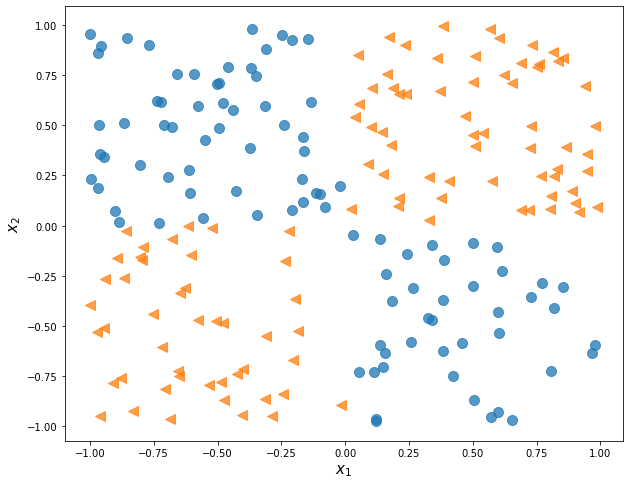

In [35]:
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(10, 8))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

Na subseção anterior, abordamos as ferramentas essenciais necessárias para implementar um classificador no *TensorFlow*. Agora precisamos decidir qual arquitetura devemos escolher para essa tarefa e o conjunto de dados. Como regra geral, quanto mais camadas tivermos, e quanto mais neurônios tivermos em cada camada, maior será a capacidade do modelo. Aqui, a capacidade do modelo pode ser pensada como uma medida de quão prontamente o modelo pode aproximar funções complexas. Embora ter mais parâmetros signifique que a rede pode ajustar a funções mais complexas, modelos maiores geralmente são mais difíceis de treinar (e propensos a *overfitting*).

Na prática, é sempre uma boa ideia começar com um modelo simples como linha de base, por exemplo, uma RN de camada única como regressão logística:

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                input_shape=(2,),
                activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


O tamanho total dos parâmetros para este modelo de regressão logística simples é 3: uma matriz de peso (ou kernel) de tamanho 2 × 1 e um vetor de viés de tamanho 1. Após definir o modelo, vamos compilar o modelo e treiná-lo por 200 épocas usando um tamanho de lote de 2:

In [37]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

hist = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=200, batch_size=2,
                    verbose=0)

Observe que `model.fit()` retorna um histórico de épocas de treinamento, o que é útil para inspeção visual após o treinamento. No código a seguir, plotaremos as curvas de aprendizado, incluindo a perda de treinamento e validação, bem como suas acurácias.

Também usaremos a biblioteca `MLxtend` para visualizar os dados de validação e o limite de decisão.

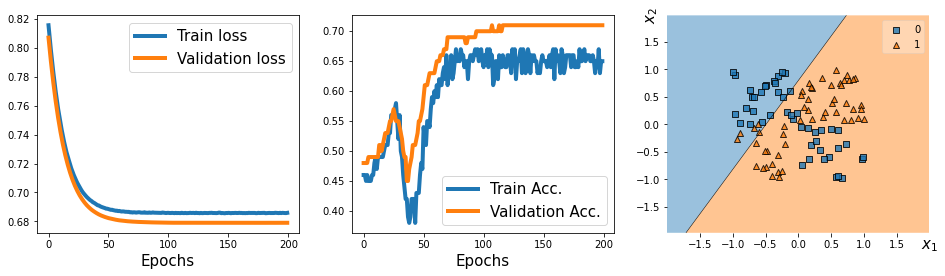

In [38]:
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                        clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

Acima o resultado apresentou uma plotagem com três painéis separados para as perdas, precisões e o gráfico de dispersão dos exemplos de validação, juntamente com o limite de decisão.

Como você pode ver, um modelo simples sem camada oculta **só pode derivar um limite de decisão linear**, que é incapaz de resolver o problema $\small XOR$. Como consequência, podemos observar que os termos de perda para os conjuntos de dados de treinamento e validação são muito altos e a precisão da classificação é muito baixa.

Para derivar um limite de decisão não linear, podemos adicionar uma ou mais camadas ocultas conectadas por meio de funções de ativação não lineares. O teorema da aproximação universal afirma que uma RN *feedforward* com uma única camada oculta e um número relativamente grande de unidades ocultas pode aproximar relativamente bem as funções contínuas arbitrárias. Assim, uma abordagem para o problema $\small XOR$, de forma mais satisfatória, é adicionar uma camada oculta e comparar diferentes números de unidades ocultas até observarmos resultados satisfatórios no conjunto de dados de validação. Adicionar mais unidades ocultas corresponderia a aumentar a largura de uma camada.

Alternativamente, também podemos adicionar mais camadas ocultas, o que tornará o modelo mais profundo. A vantagem de tornar uma rede mais profunda em vez de mais ampla é que são necessários menos parâmetros para atingir uma capacidade de modelo comparável. No entanto, uma desvantagem dos modelos profundos (versus amplos) é que os modelos profundos são propensos a desaparecer e explodir gradientes, o que os torna mais difíceis de treinar. Como exercício, tente adicionar uma, duas, três e quatro camadas ocultas, cada uma com quatro unidades ocultas. No exemplo a seguir, veremos os resultados de uma RN *feedforward* com três camadas ocultas:

In [39]:
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


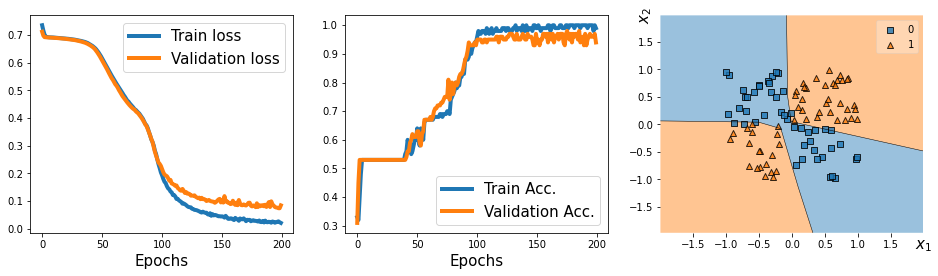

In [40]:
# Compilando o modelo acima para comparar.

model.compile(optimizer=tf.keras.optimizers.SGD(),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

# Treinando o Modelo acima para comparar.
hist = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=200, batch_size=2,
                    verbose=0)

# Plotando o resultado
history = hist.history
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                        clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

Agora, podemos ver que o modelo é capaz de derivar um limite de decisão não linear para esses dados e o modelo atinge 100% de precisão no conjunto de dados de treinamento. A precisão do conjunto de dados de validação é de 95%, o que indica que o modelo está ligeiramente **sobreajustado**.

### Tornando a construção de modelos mais flexível com a API funcional do Keras

No exemplo anterior, usamos a classe Keras `Sequential` para criar uma RN totalmente conectada com várias camadas. Esta é uma maneira muito comum e conveniente de construir modelos. No entanto, infelizmente não nos permite criar modelos mais complexos que tenham várias entradas, saídas ou ramificações intermediárias. É aí que a chamada API funcional do Keras é útil.

Para ilustrar como a API funcional pode ser usada, implementaremos a mesma arquitetura que construímos usando a abordagem orientada a objetos (`Sequencial`) na seção anterior; no entanto, desta vez, usaremos a abordagem funcional. Nesta abordagem, primeiro especificamos a entrada. Em seguida, as camadas ocultas são construídas, com suas saídas denominadas $\small h1$, $\small h2$ e $\small h3$. Para este problema, usamos a saída de cada camada como entrada para a camada sucessora (observe que, se você estiver construindo modelos mais complexos que possuem várias ramificações, isso pode não ser o caso, mas ainda pode ser feito por meio da API funcional ). Finalmente, especificamos a saída como a camada densa final que recebe $\small h3$ como entrada. O código para isso é o seguinte:



In [41]:
tf.random.set_seed(1)

# Camada de entrada
inputs = tf.keras.Input(shape=(2,))

# Camada oculta
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

# Camada de Saída
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

# Construindo o Modelo
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


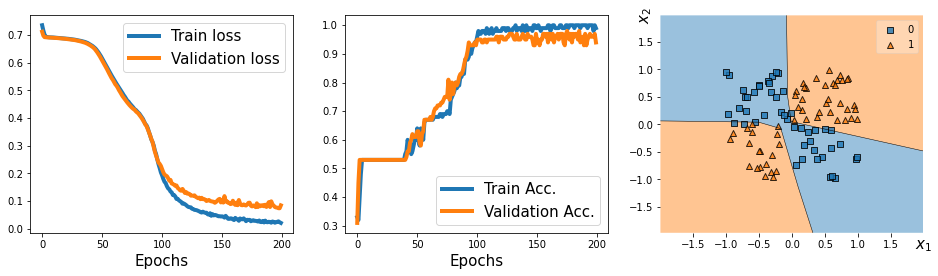

In [42]:
# Compilando o modelo
model.compile(
                optimizer=tf.keras.optimizers.SGD(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# Treinando o modelo
hist = model.fit(
                    x_train,y_train,
                    validation_data=(x_valid,y_valid),
                    epochs=200,
                    batch_size=2,
                    verbose=0
)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### Implementando modelos baseados na classe Model do *Keras*

Uma forma alternativa de construir modelos complexos é subclassificando `tf.keras.Model`. Nesta abordagem, criamos uma nova classe derivada de `tf.keras.Model` e definimos a função, `__init__()`, como um construtor. O método `call()` é usado para especificar a passagem de encaminhamento. Na função construtora, `__init__()`, definimos as camadas como atributos da classe para que possam ser acessadas através do atributo auto-referência. Então, no método `call()`, especificamos como essas camadas devem ser usadas na passagem direta do RN. O código para definir uma nova classe que implementa o modelo anterior é o seguinte:

In [43]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

Observe que usamos o mesmo nome de saída, $\small h$, para todas as camadas ocultas. Isso torna o código mais legível e fácil de seguir.
Uma classe de modelo derivada de `tf.keras.Model` por meio de subclasses herda atributos gerais de modelo, como `build()`, `compile()` e `fit()`. Portanto, uma vez que definimos uma instância dessa nova classe, podemos compilá-la e treiná-la como qualquer outro modelo construído por Keras:

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            multiple                  12        
                                                                 
 dense_14 (Dense)            multiple                  20        
                                                                 
 dense_15 (Dense)            multiple                  20        
                                                                 
 dense_16 (Dense)            multiple                  5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


C:\Users\willi\AppData\Local\Temp\ipykernel_1228\2372930084.py:34: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


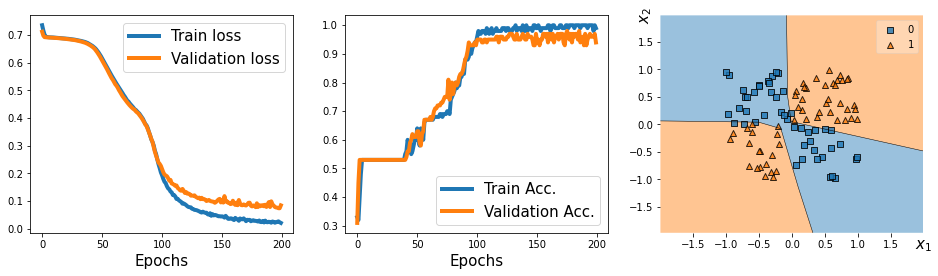

In [44]:
tf.random.set_seed(1)
# Testando o Modelo
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

## Complitando 
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## Treinando:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

## Plotando
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### Escrevendo camadas Keras personalizadas

Nos casos em que queremos definir uma nova camada que ainda não é suportada pelo *Keras*, podemos definir uma nova classe derivada da classe `tf.keras.layers.Layer`. Isso é especialmente útil ao projetar uma nova camada ou personalizar uma camada existente.

Para ilustrar o conceito de implementação de camadas personalizadas, vamos considerar um exemplo simples. Imagine que queremos definir uma nova camada linear que calcula $w(x+ \epsilon)+ b$ , onde $\epsilon$ se refere a uma variável aleatória como uma variável de ruído. Para implementar esses cálculos, definimos uma nova classe como uma subclasse de `tf.keras.layers.Layer`. Para esta nova classe, temos que definir tanto o método construtor `__init__()` quanto o método `call()`. No construtor, definimos as variáveis ​​e outros tensores necessários para nossa camada customizada. Temos a opção de criar variáveis ​​e inicializá-las no construtor se o `input_shape` for fornecido ao construtor. Alternativamente, podemos atrasar a inicialização da variável (por exemplo, se não soubermos antecipadamente a forma exata da entrada) e delegá-la ao método `build()` para a criação tardia da variável. Além disso, podemos definir `get_config()` para serialização, o que significa que um modelo usando nossa camada personalizada pode ser salvo com eficiência usando os recursos de salvamento e carregamento de modelo do *TensorFlow*.

Para ver um exemplo concreto, vamos definir uma nova camada chamada `NoisyLinear`, que implementa o cálculo $w(x+ \epsilon)+ b$, que foi mencionado no parágrafo anterior:

In [45]:
'''
Definindo a camada personalizada:
Define __init__()
Define build() para crar a variável tardia
Define call()
Define get_config() para serialização
'''
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)
        
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)

            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config

No construtor, adicionamos um argumento, `noise_stddev`, para especificar o desvio padrão para a distribuição de $\epsilon$, que é uma amostra de uma distribuição gaussiana. Além disso, observe que no método `call()` usamos um argumento adicional, `training=False`. No contexto de *Keras*, o argumento de treinamento é um argumento booleano especial que distingue se um modelo ou camada é usado durante o treinamento (por exemplo, via `fit()`) ou apenas para previsão (por exemplo, via `predict()`; isso às vezes é também chamado de "inferência" ou avaliação). Uma das principais diferenças entre o treinamento e previsão é que, durante a previsão, não exigimos gradientes. Além disso, existem certos métodos que se comportam de forma diferente nos modos de treinamento e previsão. Você encontrará um exemplo de tal método, `Dropout`. No trecho de código anterior, também especificamos que o vetor aleatório, $\epsilon$, deveria ser gerado e adicionado à entrada apenas durante o treinamento e não usado para inferência ou avaliação.

Antes de darmos um passo adiante e usarmos nossa camada `NoisyLinear` personalizada em um modelo, vamos testá-la no contexto de um exemplo simples.

No código a seguir, vamos definir uma nova instância dessa camada, inicializá-la chamando `.build()` e executá-la em um tensor de entrada. Então, vamos serializá-lo via `.get_config()` e restaurar o objeto serializado via `.from_config()`:

In [46]:
##  Testando:

tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

## Reconstruindo via config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))


[[0 0.00821428 0 0]]
[[0 0.0108502861 0 0]]


No trecho de código anterior, chamamos a camada duas vezes no mesmo tensor de entrada. No entanto, observe que as saídas diferem porque a camada `NoisyLinear` adicionou ruído aleatório ao tensor de entrada. Agora, vamos criar um novo modelo semelhante ao anterior para resolver a tarefa de classificação $\small XOR$. Como antes, usaremos a classe `Sequential` do *Keras*, mas desta vez, usaremos nossa camada `NoisyLinear` como a primeira camada oculta do *perceptron* multicamada. O código é o seguinte:

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_linear_1 (NoisyLinear  (None, 4)                12        
 )                                                               
                                                                 
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


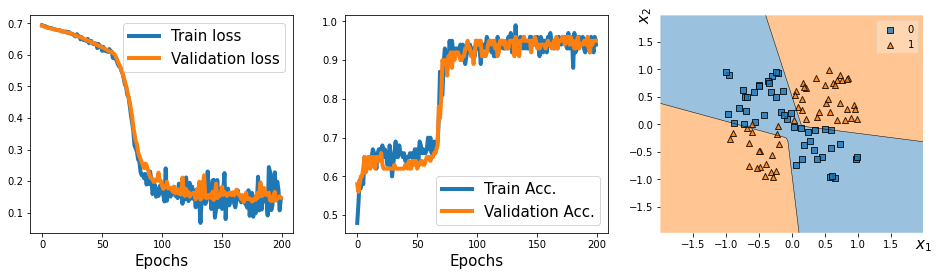

In [47]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()

## Compilando:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## treinando:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, 
                 verbose=0)

## Plotando
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

Aqui, nosso objetivo era aprender como definir uma nova camada personalizada subclassificada de `tf.keras.layers.Layer` e usá-la como usaríamos qualquer outra camada *Keras* padrão. Embora, com este exemplo em particular, o `NoisyLinear` não tenha ajudado a melhorar o desempenho, lembre-se de que nosso objetivo era principalmente aprender a escrever uma camada personalizada do zero. Em geral, escrever uma nova camada customizada pode ser útil em outros aplicativos, por exemplo, se você desenvolver um novo algoritmo que dependa de uma nova camada além das existentes.

### Estimadores do TensorFlow

Até agora, nós nos concentramos principalmente na API *TensorFlow* de baixo nível. Usamos decoradores para modificar funções para compilar os gráficos computacionais explicitamente para eficiência computacional. Em seguida, trabalhamos com a API *Keras* e implementamos RNs *feedforward*, aos quais adicionamos camadas personalizadas. 

Aqui mudaremos de marcha e trabalharemos com os Estimadores do *TensorFlow*. A API `tf.estimator` encapsula as etapas subjacentes em tarefas de aprendizado de máquina, como treinamento, previsão (inferência) e avaliação. Os estimadores são mais encapsulados, mas também mais escaláveis ​​quando comparados às abordagens anteriores que abordamos anteriormente. Além disso, a API `tf.estimator` adiciona suporte para execução de modelos em várias plataformas sem exigir grandes alterações de código, o que os torna mais adequados para a chamada "fase de produção" em aplicativos da indústria. Além disso, o *TensorFlow* vem com uma seleção de estimadores prontos para uso para arquiteturas comuns de aprendizado de máquina e aprendizado profundo que são úteis para estudos de comparação, por exemplo, para avaliar rapidamente se uma determinada abordagem é aplicável a um determinado conjunto de dados ou problema.
Mais adiante, aprenderemos como usar esses estimadores pré-fabricados e como criar um estimador a partir de um modelo *Keras* existente. Um dos elementos essenciais dos Estimadores é definir as colunas de recursos como um mecanismo para importar dados para um modelo baseado em Estimadores.

### Trabalhando com colunas de recursos
Em aplicativos de aprendizado de máquina e aprendizado profundo, podemos encontrar vários tipos diferentes de recursos: contínuo, categórico não ordenado (nominal) e categórico ordenado (ordinal). Você deve se lembrar de que existem diferentes tipos de recursos e aprendemos como lidar com cada tipo. Observe que, embora os dados numéricos possam ser contínuos ou discretos, no contexto da API do *TensorFlow*, os dados "numéricos" se referem especificamente a dados contínuos do tipo ponto flutuante.

Às vezes, os conjuntos de recursos são compostos por uma mistura de diferentes tipos de recursos. Embora os estimadores do *TensorFlow* tenham sido projetados para lidar com todos esses diferentes tipos de recursos, devemos especificar como cada recurso deve ser interpretado pelo estimador.

<img src=https://miro.medium.com/max/1400/1*IKt4cObXmW7j42pD--a-WQ.png width=500>

Os recursos mostrados na figura (ano do modelo, cilindros, cilindrada, potência, peso, aceleração e origem) foram obtidos do conjunto de dados Auto MPG, que é um conjunto de dados de benchmark de aprendizado de máquina comum para prever a eficiência de combustível de um carro em milhas por galão (MPG).

O conjunto de dados completo e sua descrição estão disponíveis no repositório de aprendizado de máquina da UCI em https://archive.ics.uci.edu/ml/datasets/auto+mpg. Vamos tratar cinco recursos do conjunto de dados Auto MPG (número de cilindros, deslocamento, potência, peso e aceleração) como recursos "numéricos" (no caso aqui, contínuos). O ano do modelo pode ser considerado como um recurso categórico (ordinal) ordenado. Por fim, a origem de fabricação pode ser considerada como uma característica categórica não ordenada (nominal) com três valores discretos possíveis, 1, 2 e 3, que correspondem aos EUA, Europa e Japão, respectivamente.

Vamos primeiro carregar os dados e aplicar as etapas de pré-processamento necessárias, como particionar o conjunto de dados em conjuntos de dados de treinamento e teste, além de padronizar os recursos contínuos:

In [48]:
tf.random.set_seed(1)
np.random.seed(1)
import pandas as pd
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       ("http://archive.ics.uci.edu/ml/machine-learning-databases"
                                        "/auto-mpg/auto-mpg.data"))

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'ModelYear', 'Origin']

df = pd.read_csv(dataset_path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True, encoding='utf-8')

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [49]:
print(df.isna().sum())

# Drop linhas Nulas
df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [50]:
# Dividindo o conjunto de dados e treino
import sklearn
import sklearn.model_selection


df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
ModelYear,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [51]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std  = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean)/std
    
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


O `DataFrame` pandas que criamos por meio do trecho de código anterior contém cinco colunas com valores do tipo `float`. Essas colunas constituirão as *features* contínuas. No código a seguir, usaremos a função `feature_column` do *TensorFlow* para transformar essas *features* contínuas na estrutura de dados da coluna de *features* com a qual os Estimadores do *TensorFlow* podem trabalhar:

In [52]:
numeric_features = []

for col_name in numeric_column_names:
    numeric_features.append(tf.feature_column.numeric_column(key=col_name))
    
numeric_features

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

Em seguida, vamos agrupar as informações de ano de modelo bastante refinadas em *buckets* para simplificar a tarefa de aprendizado para o modelo que vamos treinar mais tarde. Concretamente, vamos atribuir cada carro a um dos quatro *buckets* de "ano", da seguinte forma:

$$
\small bucket = 

\begin{cases} 0 \quad \text if \: year < 73 \\
              1 \quad \text if \: 73 \leq year \leq 76 \\
              2 \quad \text if \: 76 \leq year \leq 79 \\
              3 \quad \text if \: year \geq 79 \\

\end{cases}
$$

Observe que os intervalos escolhidos foram selecionados arbitrariamente para ilustrar os conceitos de "bucketing". Para agrupar os carros nesses *buckets*, primeiro definiremos uma *feature* numérica com base em cada ano do modelo original. Em seguida, esses recursos numéricos serão passados para a função `bucketized_column` para a qual especificaremos três valores de corte de intervalo: $\small [73, 76, 79]$. Os valores especificados incluem o valor de corte correto. Esses valores de corte são usados para especificar intervalos semifechados, por exemplo, $\small (−\infty, 73) , [73, 76) , [76, 79) e [79, \infty)$ . O código é o seguinte:

In [53]:
feature_year = tf.feature_column.numeric_column(key='ModelYear')
bucketized_features = []
bucketized_features.append( 
    tf.feature_column.bucketized_column(
        source_column=feature_year,
        boundaries=[73, 76, 79])
        )

print(bucketized_features)

[BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79))]


Para consistência, adicionamos essa coluna de *feature bucketized* a uma lista do *Python*, mesmo que a lista consista em apenas uma entrada. Nas etapas a seguir, mesclaremos essa lista com as listas feitas de outros recursos, que serão fornecidas como entrada para o modelo baseado no *TensorFlow Estimator*.

Em seguida, prosseguiremos com a definição de uma lista para o recurso categórico não ordenado, `Origin`. No *TensorFlow*, existem diferentes maneiras de criar uma coluna de recurso categórico. Se os dados contiverem os nomes das categorias (por exemplo, em formato de *string* como "EUA", "Europa" e "Japão"), podemos usar `tf.feature_column.categorical_column_with_vocabulary_list` e fornecer uma lista de nomes de categorias exclusivos e possíveis como entrada . Se a lista de categorias possíveis for muito grande, por exemplo, em um contexto típico de análise de texto, podemos usar `tf.feature_column.categorical_column_with_vocabulary_file`. Ao usar esta função, simplesmente fornecemos um arquivo que contém todas as categorias/palavras para que não tenhamos que armazenar uma lista de todas as palavras possíveis na memória. Além disso, se os recursos já estiverem associados a um índice de categorias no intervalo [0, `num_categories`), podemos usar a função `tf.feature_column.categorical_column_with_identity`. No entanto, neste caso, o recurso `Origin` é fornecido como valores inteiros 1, 2, 3 (em oposição a 0, 1, 2), o que não corresponde ao requisito de indexação categórica, pois espera que os índices comecem de 0. No exemplo de código a seguir, prosseguiremos com a lista de vocabulário:

In [54]:
feature_origin = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin',
    vocabulary_list=[1, 2, 3])

Certos estimadores, como `DNNClassifier` e `DNNRegressor`, aceitam apenas as chamadas "colunas densas". Portanto, a próxima etapa é converter a coluna de recurso categórico existente em uma coluna tão densa. Há duas maneiras de fazer isso: usando uma coluna de incorporação via `embedding_column` ou uma coluna de indicador via `indicator_column`. Uma coluna de indicador converte os índices categóricos em vetores codificados *one-hot*, por exemplo, o índice 0 será codificado como [1, 0, 0], o índice 1 será codificado como [0, 1, 0] e assim por diante. Por outro lado, a coluna *embedding* mapeia cada índice para um vetor de número aleatório do tipo `float`, que pode ser treinado.

Quando o número de categorias é grande, usar a coluna de incorporação com menos dimensões do que o número de categorias pode melhorar o desempenho. No trecho de código a seguir, usaremos a abordagem da coluna do indicador no recurso categórico para convertê-lo no formato denso:

In [55]:
categorical_indicator_features = []
categorical_indicator_features.append(tf.feature_column.indicator_column(feature_origin))

print(categorical_indicator_features)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=(1, 2, 3), dtype=tf.int32, default_value=-1, num_oov_buckets=0))]


### Aprendizado de máquina com estimadores pré-fabricados
Agora, depois de construir as colunas de recursos obrigatórias, podemos finalmente utilizar os estimadores do *TensorFlow*. O uso de estimadores pré-fabricados pode ser resumido em quatro etapas:
1. Defina uma função de entrada para carregamento de dados
2. Converta o conjunto de dados em colunas de recursos
3. Instancie um estimador (use um estimador pré-fabricado ou crie um novo, por exemplo, convertendo um modelo *Keras* em um estimador)
4. Use os métodos do Estimador `train()`, `evaluate()` e `predict()`

Continuando com o exemplo Auto MPG, aplicaremos essas quatro etapas para ilustrar como podemos usar os estimadores na prática. Para a primeira etapa, precisamos definir uma função que processe os dados e retorne um conjunto de dados do *TensorFlow* que consiste em uma tupla que contém os recursos de entrada e os rótulos (valores MPG de verdade). Observe que os recursos devem estar em **um formato de dicionário e as chaves do dicionário devem corresponder aos nomes das colunas de recursos**. Começando com o primeiro passo, vamos definir a função de entrada para os dados de treinamento da seguinte forma:

In [56]:
def train_input_fn(df_train, batch_size=8):
    df = df_train.copy()
    train_x, train_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))

    # shuffle, repeat, and batch the examples
    return dataset.shuffle(1000).repeat().batch(batch_size)

Observe que usamos `dict(train_x)` nesta função para converter o objeto `DataFrame` do pandas em um dicionário *Python*. Vamos carregar um lote desse conjunto de dados para ver como fica:

In [57]:
## Inspecionando o código
ds = train_input_fn(df_train_norm)
batch = next(iter(ds))
print('Keys:', batch[0].keys())
print('Batch Model Years:', batch[0]['ModelYear'])

Keys: dict_keys(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin'])
Batch Model Years: tf.Tensor([82 78 76 72 78 73 70 78], shape=(8,), dtype=int64)


Também precisamos definir uma função de entrada para o conjunto de dados de teste que será usado para avaliação após o treinamento do modelo:

In [58]:
def eval_input_fn(df_test, batch_size=8):
    df = df_test.copy()
    test_x, test_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(test_x), test_y))

    return dataset.batch(batch_size)

Agora, indo para a etapa 2, precisamos definir as colunas de recursos. Já definimos uma lista contendo os recursos contínuos, uma lista para a coluna de recursos agrupados e uma lista para a coluna de recursos categóricos. Agora podemos concatenar essas listas individuais em uma única lista contendo todas as colunas de recursos:

In [59]:
all_feature_columns = (numeric_features + 
                       bucketized_features + 
                       categorical_indicator_features)

print(all_feature_columns)

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=(1, 2, 3), dtype=tf.int32, default_value=-1, num_oov_buckets=0))]


Para a etapa 3, precisamos instanciar um novo *Estimador*. Como a previsão de valores de MPG é um problema típico de regressão, usaremos `tf.estimator.DNNRegressor`. Ao instanciar o *Estimador* de regressão, forneceremos a lista de colunas de recursos e especificaremos o número de unidades ocultas que queremos ter em cada camada oculta usando o argumento `hidden_units`. Aqui, usaremos duas camadas ocultas, onde a primeira camada oculta possui 32 unidades e a segunda camada oculta possui 10 unidades:

In [60]:
regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    model_dir='models/autompg-dnnregressor/')

O outro argumento, `model_dir`, que fornecemos especifica o diretório para salvar os parâmetros do modelo. Uma das vantagens dos Estimadores é que eles **verificam automaticamente o modelo durante o treinamento**, para que, caso o treinamento do modelo falhe por um motivo inesperado (como falha de energia), podemos facilmente carregar o último ponto de verificação salvo e continuar treinando a partir daí. Os pontos de verificação também serão salvos no diretório especificado por `model_dir`. Se não especificarmos o argumento `model_dir`, o Estimador criará uma pasta temporária aleatória que será utilizada para esta finalidade.

Após essas três etapas básicas de configuração, podemos finalmente usar o Estimador para treinamento, avaliação e, eventualmente, previsão. O regressor pode ser treinado chamando o método `train()`, para o qual exigimos a função de entrada definida anteriormente:

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 8
total_steps = EPOCHS * int(np.ceil(len(df_train) / BATCH_SIZE))
print('Training Steps:', total_steps)

regressor.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE),
    steps=total_steps)

Chamar `.train()` salvará automaticamente os pontos de verificação durante o treinamento do modelo. Podemos então recarregar o último *checkpoint*:

In [62]:
reloaded_regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    warm_start_from='models/autompg-dnnregressor/',
    model_dir='models/autompg-dnnregressor/')   

Então, para avaliar o desempenho preditivo do modelo treinado, podemos usar o método `evaluate()`, como segue:

In [ ]:
eval_results = reloaded_regressor.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))
    
print('Average-Loss {:.4f}'.format(eval_results['average_loss']))

Finalmente, para prever os valores alvo em novos pontos de dados, podemos usar o método `predict()`. Para os propósitos deste exemplo, suponha que o conjunto de dados de teste represente um conjunto de dados de pontos de dados novos e não rotulados em um aplicativo do mundo real.

Observe que em uma tarefa de previsão do mundo real, a função de entrada precisará retornar apenas um conjunto de dados composto por recursos, supondo que os rótulos não estejam disponíveis. Aqui, simplesmente usaremos a mesma função de entrada que usamos para avaliação para obter as previsões para cada exemplo:

In [ ]:
pred_res = regressor.predict(input_fn=lambda: eval_input_fn(df_test_norm, batch_size=8))

print(next(iter(pred_res)))

Enquanto os trechos de código anteriores concluem a ilustração das quatro etapas que são necessário para usar estimadores pré-fabricados, para praticar, vamos dar uma olhada em outro pré-made Estimator: o regressor da árvore impulsionada,`tf.estimator.BoostedTreeRegressor`. Como as funções de entrada e as colunas de recursos já estão construídas, só precisamos repita as etapas 3 e 4. Para a etapa 3, criaremos uma instância de BoostedTreeRegressor e configurá-lo para ter 200 árvores.

In [65]:
boosted_tree = tf.estimator.BoostedTreesRegressor(
    feature_columns=all_feature_columns,
    n_batches_per_layer=20,
    n_trees=200)

boosted_tree.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE))

eval_results = boosted_tree.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

print(eval_results)

print('Average-Loss {:.4f}'.format(eval_results['average_loss']))

{'average_loss': 10.125691, 'label/mean': 23.611393, 'loss': 10.023726, 'prediction/mean': 22.689522, 'global_step': 24000}
Average-Loss 10.1257


Como você pode ver, o regressor da árvore impulsionada atinge uma perda média menor do que o `DNNRegressor`. Para um conjunto de dados pequeno como esse, isso é esperado.